# Thống kê Bayes sử dụng probflow

# Bài 1: Hồi quy tuyến tính đơn biến

### BS. Lê Ngọc Khả Nhi


# Giới thiệu về probflow

Đây là bài đầu tiên trong loạt bài giới thiệu về probflow. Như những thư viện rstan, brms... trong ngôn ngữ R, thư viện probflow của tác giả Brendan Hasz (2019) là một giao thức để dựng các mô hình Bayes trong ngôn ngữ Python. probflow cho phép chọn giữa backend : tensorflow probability (mặc định) và Pytorch; 

Trước khi install probflow, các bạn cần install tensorflow phiên bản 2.0 (GPU hoặc CPU), và tensorflow probability phiên bản 0.8. Nếu bạn quen dùng Pytorch thì có thể chọn nó làm backend cho probflow mà không cần tensorflow.

Cách sử dụng probflow rất đơn giản, chỉ yêu cầu một số kiến thức cơ bản về numpy và Python OOP; ngay cả khi bạn chưa biết về OOP, vẫn có thể copy các snipet có sẵn để dùng. Đầu tiên, ta tạo 1 class mô hình, sau đó sử dụng nó như cách mà ta dùng các object mô hình scikit-learn, tức là fit với dữ liệu X và Y. 

Khi dùng tensorflow làm backend, mô hình probflow tạo ra có bản chất là một mô hình deep neural network với probability layer; method fit huấn luyện mô hình theo cơ chế mặc định hay tùy chọn (bact_size, số epoch, optimizer, hàm loss). Mô hình có thể tiếp tục cập nhật trên dữ liệu mới.

Sau khi được huấn luyện, ta có thể dùng mô hình để tiên lượng hoặc để suy diễn (theo Bayes). Cho mục tiêu suy diễn, ta sẽ lấy mẫu chuỗi MCMC cho các tham số trong mô hình. 

Việc huấn luyện, tiên lượng và suy diễn có thể dùng cả CPU nhiều core song song hoặc GPU; khi dùng GPU tốc độ tính toán có thể nhanh hơn hàng chục lần.

In [1]:
# Imports
import probflow as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

tfd =tfp.distributions

pf.set_backend('tensorflow')


# Hồi quy tuyến tính đơn biến

Trong bài này, ta sẽ làm quen với loại mô hình dơn giản nhất trong probflow, đó là mô hình hồi quy tuyến tính đơn biến, có dạng:

$y∼Normal(\mu = b0 + b1.x, \sigma)$

Trong đó x là predictor, y là kết quả giả định có phân bố Gaussian với 2 tham số $\mu$ và $\sigma$. $\mu$ là đối tượng chính ta cần suy diễn thống kê, được ước tính từ b0 và b1.x, b0 là intercept hay còn gọi là bias của mô hình, b1 còn gọi là weight hay coefficient của x.

## Bài toán minh họa

Trong bài này, Nhi sẽ dùng bộ số liệu khảo sát tính tương hợp giữa 2 phương pháp đo gián tiếp cung lượng tim (cardiac output) : TCO đo bằng Thermodilution, FCO đo bằng định luật Fick trên 15 bệnh nhân. Số liệu lấy từ nghiên cứu của Avi A. Weinbroum (Journal of Clinical Monitoring and Computing (2008) 22: 361-366).

Do TCO và FCO có cùng ý nghĩa sinh lý, cùng đơn vị đo, đây là 1 bài toán với mục tiêu hoán đổi biến số/chứng minh sự tương hợp. Ta có thể suy diễn thống kê bằng 1 mô hình hồi quy tuyến tính dơn biến, nhằm ước lượng biến kết quả Y=FCO theo X=TCO.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/kinokoberuji/Statistics-Python-Tutorials/master/cardoutput.csv', sep = ' ')

df

,Age,Diag,VO2,Svo2,Scvo2,TCO,FCO,Sex
0,66,sepsis,207,63,62,4.9,5.3,M
1,73,sepsis,300,75,78,7.4,10.2,M
2,53,sepsis,289,69,70,8.1,8.7,F
3,28,cardiogenic,150,70,71,3.1,3.7,F
4,72,cardiogenic,350,66,68,5.7,7.6,M
5,71,sepsis,150,70,72,3.1,3.7,M
6,71,sepsis,305,75,74,6.3,9.6,F
7,53,sepsis,140,74,74,3.1,3.7,M
8,57,sepsis,167,63,76,4.1,3.4,F
9,75,cardiogenic,318,64,61,6.1,6.8,F


Text(0, 0.5, 'FCO')

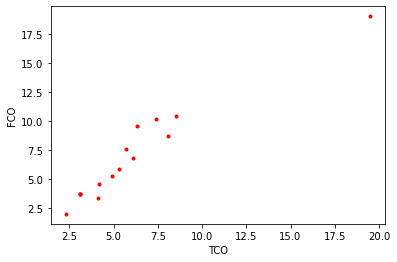

In [5]:
# Plot it
plt.plot(df['TCO'], df['FCO'], '.r')
plt.xlabel('TCO')
plt.ylabel('FCO')

In [8]:
x = df['TCO'].values.astype(np.float32)
y = df['FCO'].values.astype(np.float32)

# Dựng mô hình

## Bước 1: Thiết kế class SimpleLinearRegression

Mô hình probflow được dựng thông qua 1 class, điều này hơi khó với các bạn chưa quen dùng OOP, nhưng Nhi có thể đảm bảo rằng như thế này đã là đơn giản hơn rất nhiều so với việc bạn phải dựng thủ công mô hình xác suất bằng tensorflow probability, vì profflow đã làm giúp chúng ta nhiều công đoạn phức tạp.

In [30]:
class SimpleLinearRegression(pf.ContinuousModel):

    def __init__(self):
        self.w = pf.Parameter(name='b1')
        self.b = pf.Parameter(name='Intercept')
        self.s = pf.ScaleParameter(name='Sigma')

    def __call__(self,x):
        return pf.Normal(x*self.w()+self.b(), self.s())

In [35]:
model = SimpleLinearRegression()

probflow tự động đặt phân phối Gaussian (tham số loc, scale chưa xác định ) cho b1 và Intercept, ta có thể thay đổi tham số bên trong:

In [15]:
model.w.prior

In [16]:
model.b.prior

In [36]:
model.w.prior = tfd.Normal(loc = 0., scale = 1.)
model.b.prior = tfd.Normal(loc = 0., scale = 1.)

In [18]:
model.w.prior

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [19]:
model.b.prior

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

## Bước 2: Huấn luyện (fit, train) mô hình

Mô hình probflow có bản chất là 1 mô hình deep learning, và có thể train với cú pháp gần giống như trong keras

Ở đây do x chỉ có 15 instances, nên ta dùng toàn bộ set (batch_size = 15), và 50 epochs

In [41]:
model.fit(x, y,
          batch_size = 15, 
          epochs = 50,
          shuffle = True)

## Bước 3: Tiên lượng và kiểm định

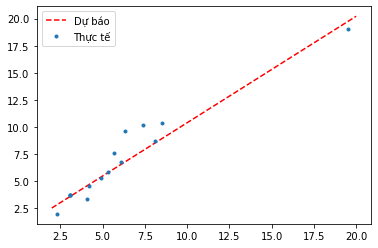

In [43]:
# Make predictions
x_test = np.array([2,20]).astype('float32')
preds = model.predict(x_test)

# Plot em
plt.plot(x_test, preds, 'r--', label = 'Dự báo')
plt.plot(x, y, '.', label = 'Thực tế')
plt.legend()

Một điều thú vị, ta có thể tính hệ số R-square của mô hình cho từng trường hợp, và tính R2 trung bình cùng khoảng tin cậy:

In [50]:
pd.Series(model.r_squared(x,y)).describe(percentiles=[0.025, 0.5, 0.975])

count    1000.000000
mean        0.909409
std         0.037681
min         0.616705
2.5%        0.795718
50%         0.924499
97.5%       0.933435
max         0.933443
dtype: float64

## Bước 4: Suy diễn Bayes (chuỗi MCMC)

Từ mô hình, ta có thể lấy mẫu chuỗi MCMC với kích thước bất kì, thí dụ Nhi tạo 1 chuỗi MCMC 5000 lượt:

In [51]:
mcmc = model.posterior_sample(n=5000)

mcmc

{'b1': array([[1.1503282],
        [1.1106896],
        [1.1577055],
        ...,
        [0.9480086],
        [0.8160565],
        [1.1650848]], dtype=float32),
 'Intercept': array([[-3.2089586 ],
        [ 1.220474  ],
        [ 1.1586881 ],
        ...,
        [-0.45812243],
        [ 1.2268338 ],
        [ 1.2630498 ]], dtype=float32),
 'Sigma': array([[2.5556843],
        [3.1783981],
        [3.105228 ],
        ...,
        [3.6315086],
        [2.4153996],
        [1.7423139]], dtype=float32)}

Bằng 1 thủ thuật nhỏ, ta có thể cắt chuỗi này thành 5 đoạn ngắn hơn dài 1000 lượt:

In [54]:
for p in mcmc.keys():
    mcmc[p] = mcmc[p].flatten().reshape(5,1000)

Tiếp theo, ta dùng thư viện arviz để làm suy diễn Bayes:

In [53]:
import arviz as az

In [56]:
az_trace = az.from_dict(mcmc)

az_trace.posterior

<xarray.Dataset>
Dimensions:    (chain: 5, draw: 1000)
Coordinates:
  * chain      (chain) int32 0 1 2 3 4
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    b1         (chain, draw) float32 1.1503282 1.1106896 ... 0.8160565 1.1650848
    Intercept  (chain, draw) float32 -3.2089586 1.220474 ... 1.2268338 1.2630498
    Sigma      (chain, draw) float32 2.5556843 3.1783981 ... 2.4153996 1.7423139
Attributes:
    created_at:     2020-05-14T18:28:07.692812
    arviz_version:  0.7.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CA6ECED6C8>,
      dtype=object)

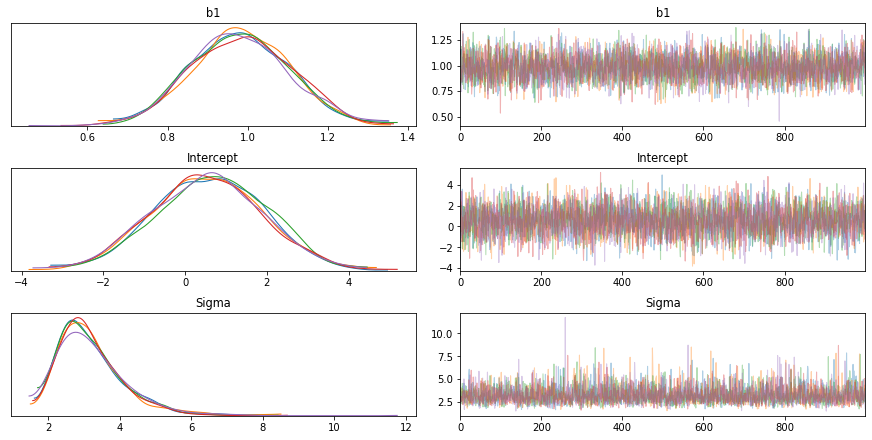

In [57]:
az.plot_trace(az_trace, compact=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001CA6F1BBBC8>,
      dtype=object)

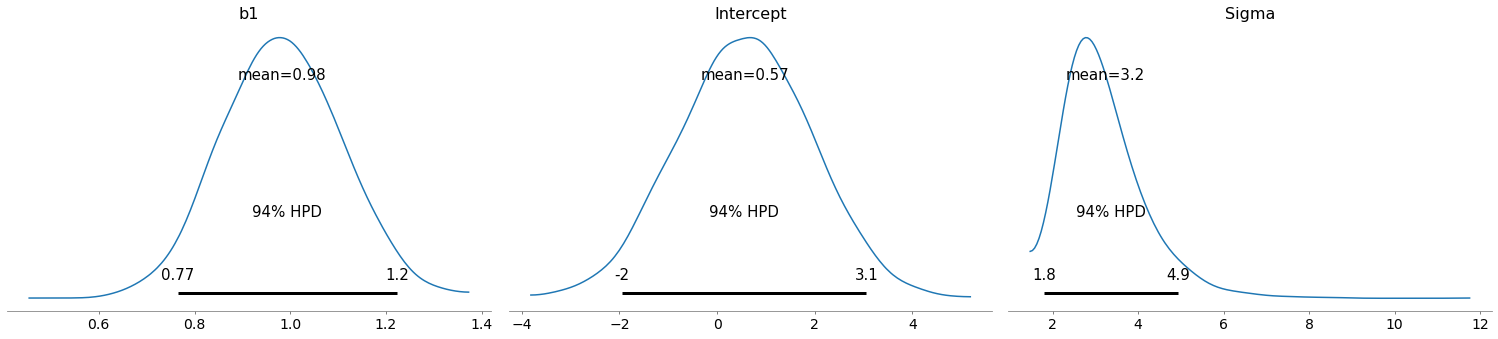

In [58]:
az.plot_posterior(az_trace)

In [59]:
az.summary(az_trace, credible_interval = 0.95)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b1,0.982,0.123,0.751,1.227,0.002,0.001,4844.0,4833.0,4850.0,4915.0,1.0
Intercept,0.567,1.354,-1.957,3.274,0.020,0.014,4371.0,4371.0,4368.0,4562.0,1.0
Sigma,3.218,0.935,1.784,5.097,0.013,0.009,5085.0,5048.0,5006.0,4592.0,1.0


Nếu không dùng arviz, ta có thể làm thủ công như sau:

In [62]:
mcmc = model.posterior_sample(n=5000)

for p in mcmc.keys():
    mcmc[p] = mcmc[p].flatten()

In [63]:
pd.DataFrame(mcmc).describe(percentiles=[0.025,0.5,0.975]).T

,count,mean,std,min,2.5%,50%,97.5%,max
b1,5000.0,0.979919,0.123161,0.524136,0.734601,0.980251,1.225081,1.399092
Intercept,5000.0,0.595919,1.333804,-4.170122,-1.971050,0.603289,3.250138,5.542350
Sigma,5000.0,3.254045,0.977242,1.489010,1.948614,3.064111,5.707281,10.886747


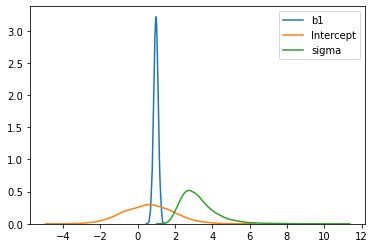

In [66]:
sns.kdeplot(mcmc['b1'], label = 'b1')    
sns.kdeplot(mcmc['Intercept'], label = 'Intercept')    
sns.kdeplot(mcmc['Sigma'], label = 'sigma')

Text(0, 0.5, 'b1')

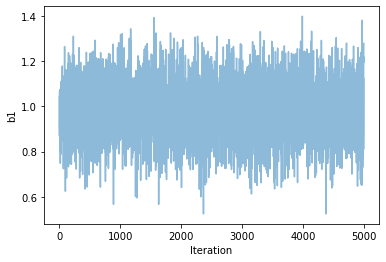

In [70]:
plt.plot(mcmc['b1'], label = 'b1', alpha = 0.5)
plt.xlabel('Iteration')
plt.ylabel('b1')

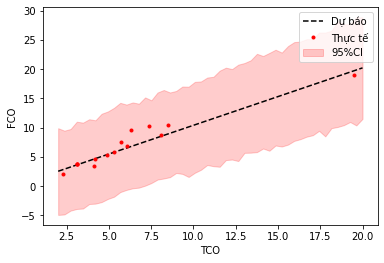

In [77]:
x_eval = np.linspace(2, 20, 50).astype('float32')
lb, ub = model.predictive_interval(x_eval, ci=0.95)

plt.fill_between(x_eval, lb, ub, alpha=0.2, color='red', label = '95%CI')
plt.plot(x_test, preds, 'k--', label = 'Dự báo')
plt.plot(x, y, '.r', label = 'Thực tế')
plt.xlabel('TCO')
plt.ylabel('FCO')
plt.legend()

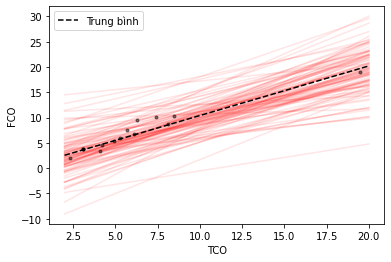

In [85]:
x_eval = np.array([2, 20]).astype('float32')
samples = model.predictive_sample(x_eval, n=100)

x_plot = np.broadcast_to(x_eval[:, np.newaxis], samples.T.shape)
plt.plot(x_plot, samples.T, 'r', alpha = 0.1)
plt.plot(x_test, preds, 'k--', label = 'Trung bình')
plt.plot(x, y, 'k.', alpha = 0.5)
plt.xlabel('TCO')
plt.ylabel('FCO')
plt.legend()

# Kết luận

Bài thực hành đến đây tạm dừng, như các bạn thấy, probflow là một thư viện Python đơn giản nhưng đầy tiềm năng cho phép người dùng phổ thông tiếp cận với phương pháp suy luận thống kê Bayes một cách dễ dàng hơn mà không cần biết nhiều về kĩ năng lập trình xác suất. probflow có thể so sánh với brms trong ngôn ngữ R.

Trong các bài tới, chúng ta sẽ tìm hiểu về những mô hình phức tạp hơn mà probflow có thể hỗ trợ. Hẹn gặp lại...